# Определение токсичности комментариев

## Получение и изучение данных

###  Поставленная задача и исходные данные

**Заказчик: Интернет-магазин «Викишоп»** 

    
**Цель**

Предоставить магазину инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Задачи**

- обучить модель классифицировать комментарии на позитивные и негативные.
- построить модель со значением метрики качества F1 не меньше 0.75.

**Описание данных**

Заказчик предоставил набор данных с разметкой о токсичности правок, cтолбец `text` в нём содержит текст комментария, а `toxic` — **целевой признак**.

### Импорт библиотек и базовые настройки

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_colwidth', 100)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = '13'

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set2')

import re 

import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kirill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kirill\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kirill\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Kirill\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kirill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Для удобства вывода на печать создадим класс для работы с текстом

In [2]:
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'

Загрузите и подготовьте данные.

### Обзор и предообработка данных

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [6]:
df.tail()

,text,toxic
159566,""":::::And for the second time of asking, when your view completely contradicts the coverage in r...",0
159567,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61....,0
159568,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159569,And it looks like it was actually you who put on the speedy to have the first version deleted no...,0
159570,"""\nAnd ... I really don't think you understand. I came here and my idea was bad right away. Wh...",0


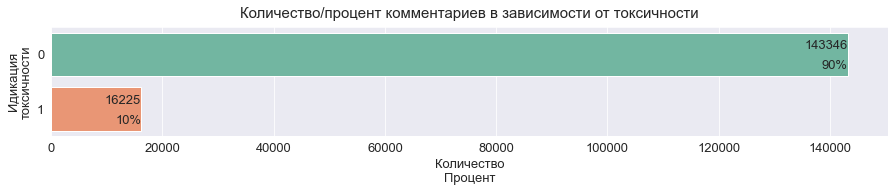

In [7]:
plt.figure(figsize=(15, 2))
plt.title('Количество/процент комментариев в зависимости от токсичности', fontsize=15, y=1.03)

ax = sns.countplot(data=df, y='toxic', hue='toxic', dodge=False)

plt.xlabel('Количество\nПроцент')
plt.ylabel('Идикация\nтоксичности')
ax.get_legend().remove()

total = len(df)
for p in ax.patches:
        ax.annotate('{:.0f}%'.format(100 * p.get_width()/total),
                    (p.get_x() + p.get_width() - 1000, p.get_y() + p.get_height()/1.3),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='right',
                    va='center')
        ax.annotate('%.0f' % p.get_width(),
                    (p.get_x() + p.get_width() - 1000, p.get_y() + p.get_height()/3.2),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='right',
                    va='center') 

In [8]:
df.duplicated().sum()

0

- 159571 строка
- пропуски отсутствуют
- явные дубликы отсутствуют
- в столбце `text` комментарии англоязычные
- в столбе `toxic` булевые значения является ли комментарий токсичным или нет, 1 - является, 0 - не является
- 90% комментариев не токсичны

## Подготовка данных

### Очистка и лемматизация текста

In [9]:
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [10]:
def lemmatize_text(text):
    clear_text = re.sub(r'[^a-z]', ' ', text.lower())              # выбор только символов и пробелов в лемматизированном тексте
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(clear_text))
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged) # добавление POS-тегов
    lemmatized_text = []
    lemmatizer = WordNetLemmatizer()  
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_text.append(word)                            # функции lemmatize() передадим «лемматизируй это»
        else:
            lemmatized_text.append(lemmatizer.lemmatize(word, tag)) # функции lemmatize() передадим «лемматизируй это»
    return ' '.join(lemmatized_text)                                # функцией join() объединим элементы списка в строку

In [11]:
%%time
df['lemm_text'] = df['text'].apply(lemmatize_text)

CPU times: total: 10min 23s
Wall time: 10min 30s


In [12]:
df = df[['toxic', 'lemm_text']]

In [13]:
df.head()

,toxic,lemm_text
0,0,explanation why the edits make under my username hardcore metallica fan be revert they weren t v...
1,0,d aww he match this background colour i m seemingly stick with thanks talk january utc
2,0,hey man i m really not try to edit war it s just that this guy be constantly remove relevant inf...
3,0,more i can t make any real suggestion on improvement i wonder if the section statistic should be...
4,0,you sir be my hero any chance you remember what page that s on


Лемматизация и очищение исходного текста выполнены.

Проверим полученный датасет на явные дубликаты.

In [14]:
print(f'\033[1mКоличество явных дубликатов: {df.duplicated().sum()}\n')

Количество явных дубликатов: 1311



Удалим явные дубликаты

In [15]:
df = df.drop_duplicates().reset_index(drop=True)
print(f'\033[1mКоличество явных дубликатов: {df.duplicated().sum()}\n')

Количество явных дубликатов: 0



### Деление данных на выборки

#### Функция создания переменных для фичей и таргета, деление на выборки

Создадим функцию `split_data()`, на вход которой подаётся:
- `df` - датафрейм для соответствующей модели,
- `valid` - флаг наличия валидационной выборки (True или False).

На выходе функции:
- при налиии валидационной выборки:

    - `target` - целевой признак,
    - `target_train` - целевой признак обучающей выборки,
    - `target_valid` - целевой признак валидационной выборки, 
    - `target_test` - целевой признак тестовой выборки,
    - `features` - признаки,
    - `features_train` - признаки обучающей выборки,
    - `features_valid` - признаки валидационной выборки,
    - `features_test` - признаки тестовой выборки.
    
    
- при отсутствии валидационной выборки:

    - `target` - целевой признак,
    - `target_train` - целевой признак обучающей выборки,
    - `target_test` - целевой признак тестовой выборки,
    - `features` - признаки,
    - `features_train` - признаки обучающей выборки,
    - `features_test` - признаки тестовой выборки.

In [16]:
def split_data (df: pd.DataFrame,
                valid: 'bool - True or False'):
    
    '''Создание переменных для признаков и целевого признака'''
    
    target = df['toxic']
    features = df['lemm_text']
    
    '''Деление данных на выборки'''
    
    if valid == True:
        features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                      target,
                                                                                      shuffle=True,
                                                                                      test_size=.4,
                                                                                      random_state=2007)
        features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                                                    target_valid,
                                                                                    shuffle=True,
                                                                                    test_size=.5,
                                                                                    random_state=2007)
        
        '''Визуализация процентного соотношения размеров выборок'''
        
        selections = pd.Series({'обучающая': len(target_train),
                                'валидационная': len(target_valid),
                                'тестовая': len(target_test)})
        
        fig = plt.figure(figsize=(10, 4))
    
        pie_selections=selections.plot(kind='pie',
                                       label='',
                                       autopct='%1.0f%%',
                                       title='Соотношение\nразмеров выборок',
                                       shadow=True,
                                       wedgeprops={'lw':1, 'ls':'-','edgecolor':"k"},
                                       colors = ['lightseagreen', 'hotpink', 'gold'],
                                       fontsize=13)
        pie_selections.title.set_size(15)  
        
        return target, target_train, target_valid, target_test, features, features_train, features_valid, features_test
    
    else:
        features_train, features_test, target_train, target_test = train_test_split(features,
                                                                                    target,
                                                                                    shuffle=True,
                                                                                    test_size=.2,
                                                                                    random_state=2007)
        
        '''Визуализация процентного соотношения размеров выборок'''
        
        selections = pd.Series({'обучающая': len(target_train),
                                'тестовая': len(target_test)})
        
        fig = plt.figure(figsize=(10, 4))
    
        pie_selections=selections.plot(kind='pie',
                                       label='',
                                       autopct='%1.0f%%',
                                       title='Соотношение\nразмеров выборок',
                                       shadow=True,
                                       wedgeprops={'lw':1, 'ls':'-','edgecolor':"k"},
                                       colors = ['lightseagreen', 'hotpink', 'gold'],
                                       fontsize=13)
        pie_selections.title.set_size(15)  
        
        return target, target_train, target_test, features, features_train, features_test

#### Создание переменных для фичей и таргета, деление на выборки

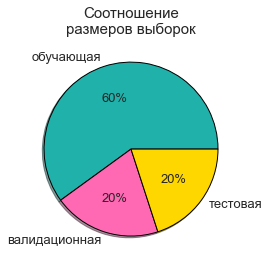

In [17]:
(y,
 y_train,
 y_valid,
 y_test,
 X,
 X_train,
 X_valid,
 X_test) = split_data (df, valid = True)

### TF-IDF

Оценка важности слова определяется величиной `TF-IDF` (от англ. term frequency, «частота терма, или слова»; inverse document frequency, «обратная частота документа, или текста»).

`TF` отвечает за количество упоминаний слова в отдельном тексте, а `IDF` отражает частоту его употребления во всём корпусе.

Вычислим `TF-IDF` для корпусов текстов.

Функцию `fit()` запускаем только на обучающей выборке, иначе тестирование будет нечестным: в модели будут учтены частоты слов из тестовой выборки.

In [18]:

stopwords    = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)  # создадим счётчик, указав в нём стоп-слова
train_tfidf  = count_tf_idf.fit_transform(X_train)    # обучение и расчёт TF-IDF для корпуса текстов train
valid_tfidf  = count_tf_idf.transform(X_valid)        # расчёт TF-IDF для корпуса текстов valid
test_tfidf   = count_tf_idf.transform(X_test)         # расчёт TF-IDF для корпуса текстов test


In [19]:
print('Размер матрицы train_tfidf:', train_tfidf.shape)
print('Размер матрицы train_tfidf:', valid_tfidf.shape)
print('Размер матрицы test_tfidf:', test_tfidf.shape)

Размер матрицы train_tfidf: (94956, 116011)
Размер матрицы train_tfidf: (31652, 116011)
Размер матрицы test_tfidf: (31652, 116011)


## Машинное обучение

### Сохранение минимального значения F1

In [20]:
f1_min = 0.75

### Функция обучения, предсказаний и получения метрик модели на валидации

Cоздадим функцию `model_metrics()`.

На входе функции:
- `model_name` - наименование модели классификации
- `parameter_change` - наименование изменяемого гиперпараметра
- `parameter_range` - диапазон изменения гиперпараметра
- `parameters_other` - словарь дополнительных параметров, если дополнительные параметры отсутствуют, то необходимо передать пустой словарь {}
- `train_tfidf` - матрица TF-IDF для обучающей выборки
- `y_train` - целевой признак обучающей выборки
- `valid` - флаг наличия валидационной выборки (True или False).

На выходе функции:
- `model_best` - лучшая модель
- `metrics` - датафрейм с метриками модели
- `f1_best` - лучшее значение метрики `F1`

Датафрейм `metrics`:
- `model` - модель     
- `f1` - значение метрики F1 для выбранной модели      
- `f1_base` - значение метрики F1 для базовой (константной) модели   
- `f1_max` - предельное значение метрики F1 согласно исходным данным
- `sanity` - вменяемость модели (**True** - вменяема, **False** - нет)    
- `quality` - качество модели относительно предельного (**True** - лучше, **False** - хуже)    
- `time_fit` - время обучения модели 
- `time_pred` - время предсказания модели
- `f'{parameter_change}'` - значения изменяемого гиперпараметра

Функция также выполняет визуализацию результатов на тепловых картах.

In [21]:
def model_metrics(model_name:'ModelClassifier',
                  parameter_change:'str_name',
                  parameter_range:'range',
                  parameters_other:'dict',
                  train_tfidf,
                  y_train,
                  valid:'bool - True or False'):
    
    time_fit_list = []
    time_pred_list = []
    f1_list = []
    sanity_list = []
    quality_list = []
    
    '''Baseline'''
    
    clf_dummy = DummyClassifier(strategy='uniform', random_state=2007) # инициализация модели
    clf_dummy.fit(train_tfidf, y_train)                                # обучение
    predictions_base = clf_dummy.predict(valid_tfidf)                  # предсказания 
    f1_base = f1_score(y_valid, predictions_base)                      # вычисление F1
    f1_best = f1_base

    '''Обучение, предсказания модели, вычисление времени кода'''
    
    for parameter in parameter_range:
            
        if model_name == LGBMClassifier or model_name == CatBoostClassifier:
            
            if model_name == LGBMClassifier:            
                params = {**{'force_col_wise'       : True,
                             'n_estimators'         : 1000,
                             'num_leaves'           : 40,
                             'random_state'         : 2007,
                             parameter_change       : parameter},
                            
                          **parameters_other}
            else:
                if valid == True:
                    params = {**{'eval_metric'          : 'F1',
                                 'n_estimators'         : 1000,
                                 'random_seed'          : 2007,
                                 parameter_change       : parameter},
                                
                              **parameters_other}
                else:
                    params = {**{'n_estimators'         : 1000,
                                 'random_seed'          : 2007,
                                 parameter_change       : parameter},
                                
                              **parameters_other}                    
        
            model = model_name(**params)
            
            start_fit = time.time()
            
            if valid == True:
                model.fit(train_tfidf,
                          y_train,
                          eval_set=(valid_tfidf, y_valid),
                          verbose=False,
                          early_stopping_rounds=200)                   # обучение модели
            else:
                model.fit(train_tfidf,
                          y_train,
                          verbose=False)                               # обучение модели                
            
            time_fit = time.time() - start_fit                         # время обучения модели
            
        else:
            
            params = {**{'random_state'         : 2007,
                         parameter_change       : parameter},
                        
                      **parameters_other}
        
            model = model_name(**params)
            
            start_fit = time.time()
            model.fit(train_tfidf, y_train)                           # обучение модели
            time_fit = time.time() - start_fit                        # время обучения модели          
            
        time_fit_list.append(time_fit)
        
        start_pred = time.time()
        
        if valid == True:
            predictions = model.predict(valid_tfidf)                  # предсказания модели
        else:
            predictions = model.predict(train_tfidf)                  # предсказания модели
        
        time_pred = time.time() - start_pred                          # время предсказания модели
        
        time_pred_list.append(time_pred)
        
        if valid == True:
            f1 = f1_score(y_valid, predictions)                       # вычисление F1
        else:
            f1 = f1_score(y_train, predictions)                       # вычисление F1            
            
        f1_list.append(f1)      
        sanity_list.append(f1 > f1_base)
        quality_list.append(f1 > f1_min)
        
        '''Выбор лучшей модели'''
        
        if f1 > f1_best:
            model_best = model
            f1_best = f1
            best_parameter = parameter
    
    '''Вывод метрик'''
    
    metrics = pd.DataFrame({'model'               : [model_name]*len(parameter_range),
                            'f1'                  : f1_list,
                            'f1_base'             : [f1_base]*len(parameter_range),
                            'f1_min'              : [f1_min]*len(parameter_range),
                            'sanity'              : sanity_list,
                            'quality'             : quality_list,
                            'time_fit'            : time_fit_list,
                            'time_pred'           : time_pred_list,
                            f'{parameter_change}' : parameter_range}) 
    
    display(metrics)
    
    if f1_best > f1_base:
        print(color.OKGREEN+color.BOLD+'Качество выбранной модели лучше базового уровня, модель вменяема.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество выбранной модели уступает базовому уровню, модель невменяема.'+color.END)
    
    if f1_best > f1_min:
        print(color.OKGREEN+color.BOLD+'Качество выбранной модели лучше предельного по исходным данным.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество выбранной модели уступает предельному по исходным данным.'+color.END)        
   
    '''Тепловая карта'''  

    fig, ax = plt.subplots(1, 3, figsize=(18,4))
    
    fig.subplots_adjust(wspace=1.0)
    
    fig.suptitle('Сравнение результатов обучения на тепловых картах', y = 1.1, fontsize = 18)
    
    for i, cmap, title, met in zip(range(3),
                                   ['RdYlGn', 'RdYlGn_r', 'RdYlGn_r'],
                                   ['Метрика\nF1',
                                    'Время\nобучения',
                                    'Время\nпредсказания'],                                            
                                   ['f1', 'time_fit', 'time_pred']):
        
        metrics_heat = metrics.set_index(f'{parameter_change}')[[met]]
        
        sns.heatmap(metrics_heat,
                    annot=True,
                    annot_kws={"size": 14},
                    fmt= '.3f',
                    ax=ax[i],
                    cmap=cmap,
                    linewidths=1.0)
        
        ax[i].set_title(f'{title}', fontsize = 14, y=1.005);    
    
    return model_best, metrics, f1_best

### LogisticRegression

#### Обучение, предсказания и получение метрик модели

,model,f1,f1_base,f1_min,sanity,quality,time_fit,time_pred,solver
0,<class 'sklearn.linear_model._logistic.LogisticRegression'>,0.726,0.171,0.750,True,False,2.499,0.005,newton-cg
1,<class 'sklearn.linear_model._logistic.LogisticRegression'>,0.726,0.171,0.750,True,False,0.853,0.004,liblinear
2,<class 'sklearn.linear_model._logistic.LogisticRegression'>,0.726,0.171,0.750,True,False,2.408,0.004,lbfgs


Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели уступает предельному по исходным данным.
CPU times: total: 6.27 s
Wall time: 6.22 s


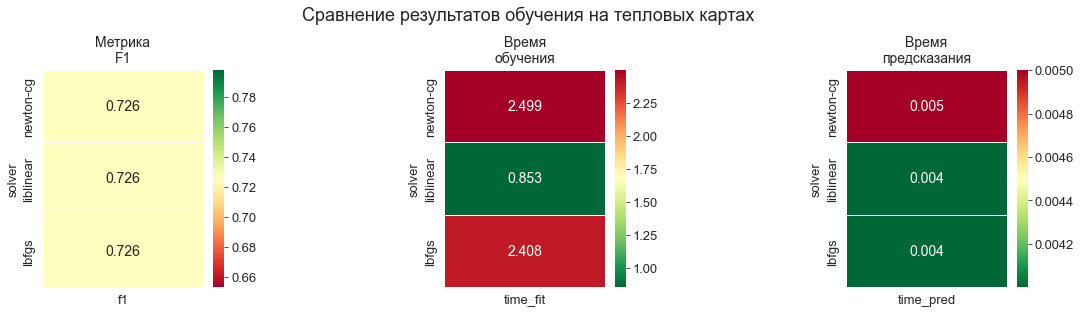

In [22]:
%%time
model_logistic, metrics_logistic, f1_logistic = model_metrics(LogisticRegression,
                                                              'solver',
                                                              ['newton-cg', 'liblinear', 'lbfgs'],
                                                              {'max_iter' : 1000},
                                                              train_tfidf,
                                                              y_train,
                                                              valid = True)

#### Лучшая модель

Гиперпараметры лучшей модели

In [23]:
model_logistic.set_params()

LogisticRegression(max_iter=1000, random_state=2007, solver='newton-cg')

Качество лучшей модели

In [24]:
print(f'F1 лучшей модели: {f1_logistic:.3f}')

F1 лучшей модели: 0.726


### DecisionTreeClassifier

#### Обучение, предсказания и получение метрик модели

,model,f1,f1_base,f1_min,sanity,quality,time_fit,time_pred,max_depth
0,<class 'sklearn.tree._classes.DecisionTreeClassifier'>,0.703,0.171,0.750,True,False,20.638,0.026,50
1,<class 'sklearn.tree._classes.DecisionTreeClassifier'>,0.711,0.171,0.750,True,False,27.539,0.015,70
2,<class 'sklearn.tree._classes.DecisionTreeClassifier'>,0.719,0.171,0.750,True,False,39.549,0.018,100


Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели уступает предельному по исходным данным.
CPU times: total: 1min 27s
Wall time: 1min 28s


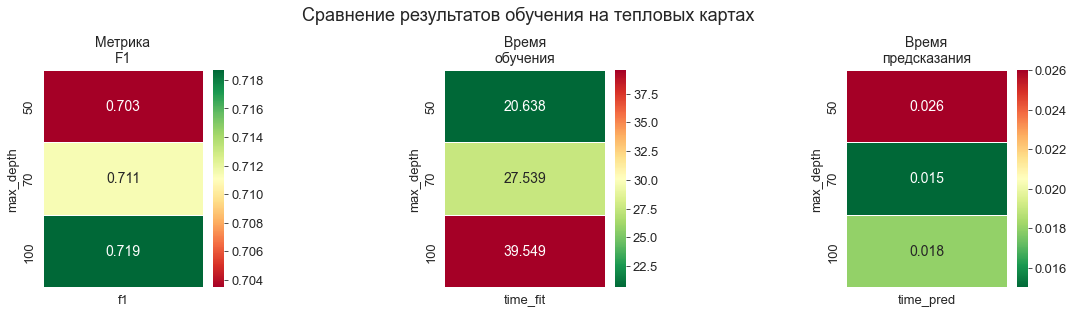

In [25]:
%%time
model_tree, metrics_tree, f1_tree = model_metrics(DecisionTreeClassifier,
                                                  'max_depth',
                                                  [50, 70, 100],
                                                  {},
                                                  train_tfidf,
                                                  y_train,
                                                  valid = True)

#### Лучшая модель

Гиперпараметры лучшей модели

In [26]:
model_tree.set_params()

DecisionTreeClassifier(max_depth=100, random_state=2007)

Качество лучшей модели

In [27]:
print(f'F1 лучшей модели: {f1_tree:.3f}')

F1 лучшей модели: 0.719


### RandomForestClassifier

#### Обучение, предсказания и получение метрик модели

,model,f1,f1_base,f1_min,sanity,quality,time_fit,time_pred,n_estimators
0,<class 'sklearn.ensemble._forest.RandomForestClassifier'>,0.657,0.171,0.750,True,False,16.636,0.223,5
1,<class 'sklearn.ensemble._forest.RandomForestClassifier'>,0.656,0.171,0.750,True,False,63.446,0.884,20
2,<class 'sklearn.ensemble._forest.RandomForestClassifier'>,0.671,0.171,0.750,True,False,126.347,1.751,40


Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели уступает предельному по исходным данным.
CPU times: total: 3min 29s
Wall time: 3min 29s


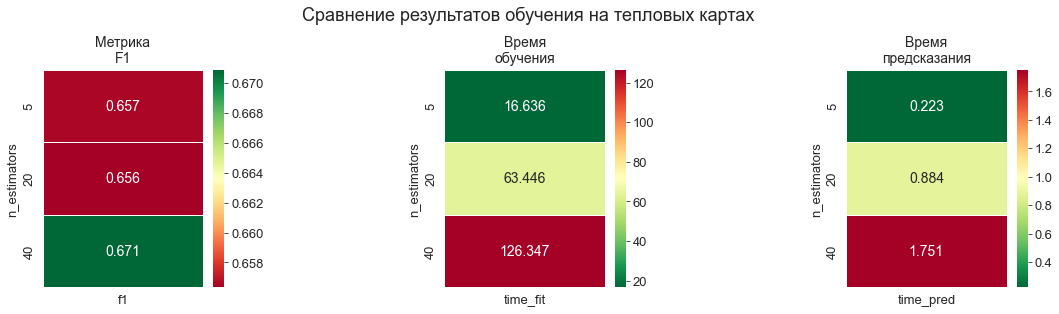

In [28]:
%%time
model_forest, metrics_forest, f1_forest = model_metrics(RandomForestClassifier,
                                                        'n_estimators',
                                                        [5, 20, 40],
                                                        {},
                                                        train_tfidf,
                                                        y_train,
                                                        valid = True)

#### Лучшая модель

Гиперпараметры лучшей модели

In [29]:
model_forest.set_params()

RandomForestClassifier(n_estimators=40, random_state=2007)

Качество лучшей модели

In [30]:
print(f'F1 лучшей модели: {f1_forest:.3f}')

F1 лучшей модели: 0.671


### CatBoostClassifier

#### Обучение, предсказания и получение метрик модели

,model,f1,f1_base,f1_min,sanity,quality,time_fit,time_pred,learning_rate
0,<class 'catboost.core.CatBoostClassifier'>,0.759,0.171,0.750,True,True,1037.011,0.543,0.250
1,<class 'catboost.core.CatBoostClassifier'>,0.763,0.171,0.750,True,True,943.305,0.604,0.400
2,<class 'catboost.core.CatBoostClassifier'>,0.763,0.171,0.750,True,True,889.641,0.642,0.600


Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.
CPU times: total: 2h 38min 43s
Wall time: 47min 52s


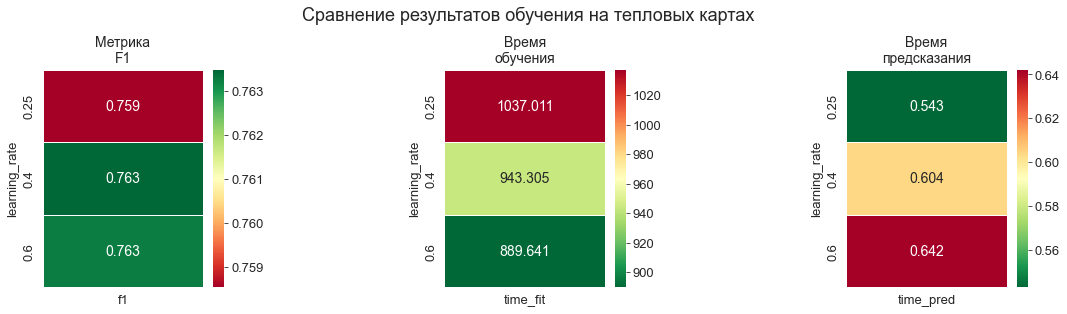

In [31]:
%%time
model_cat, metrics_cat, f1_cat = model_metrics(CatBoostClassifier,
                                               'learning_rate',
                                               [0.25, 0.4, 0.6],
                                               {},
                                               train_tfidf,
                                               y_train,
                                               valid = True)

#### Лучшая модель

Гиперпараметры лучшей модели

In [32]:
model_cat.get_params()

{'learning_rate': 0.4,
 'random_seed': 2007,
 'eval_metric': 'F1',
 'n_estimators': 1000}

Качество лучшей модели

In [33]:
print(f'F1 лучшей модели: {f1_cat:.3f}')

F1 лучшей модели: 0.763


### LGBMClassifier

#### Обучение, предсказания и получение метрик модели

,model,f1,f1_base,f1_min,sanity,quality,time_fit,time_pred,learning_rate
0,<class 'lightgbm.sklearn.LGBMClassifier'>,0.773,0.171,0.750,True,True,74.074,1.324,0.100
1,<class 'lightgbm.sklearn.LGBMClassifier'>,0.772,0.171,0.750,True,True,54.560,0.526,0.200
2,<class 'lightgbm.sklearn.LGBMClassifier'>,0.770,0.171,0.750,True,True,38.829,0.423,0.300


Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.
CPU times: total: 10min 36s
Wall time: 2min 50s


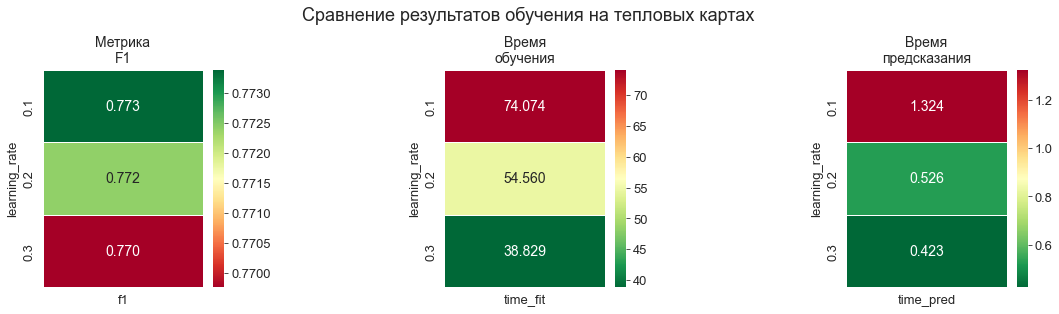

In [34]:
%%time
model_light, metrics_light, f1_light = model_metrics(LGBMClassifier,
                                                     'learning_rate',
                                                     [0.1, 0.2, 0.3],
                                                     {},
                                                     train_tfidf,
                                                     y_train,
                                                     valid = True)

,model,f1,f1_base,f1_min,sanity,quality,time_fit,time_pred,max_depth
0,<class 'lightgbm.sklearn.LGBMClassifier'>,0.760,0.171,0.750,True,True,50.693,0.884,5
1,<class 'lightgbm.sklearn.LGBMClassifier'>,0.764,0.171,0.750,True,True,71.883,1.237,10
2,<class 'lightgbm.sklearn.LGBMClassifier'>,0.773,0.171,0.750,True,True,68.025,1.192,50


Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.
CPU times: total: 12min 16s
Wall time: 3min 14s


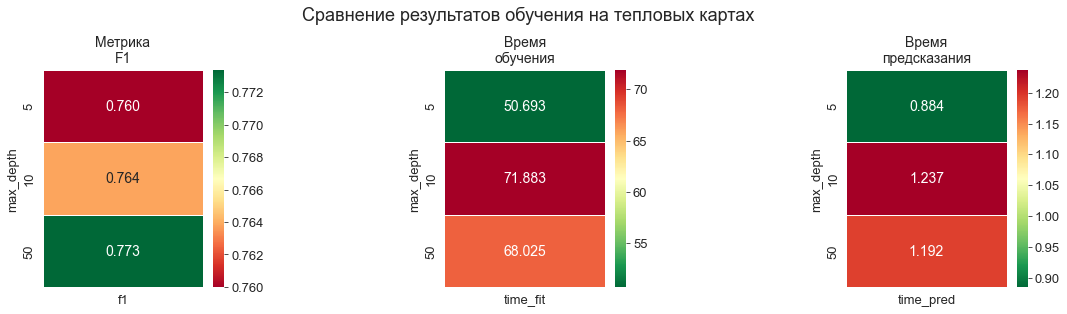

In [35]:
%%time
model_light, metrics_light, f1_light = model_metrics(LGBMClassifier,
                                                     'max_depth',
                                                     [5, 10, 50],
                                                     {'learning_rate':0.1},
                                                     train_tfidf,
                                                     y_train,
                                                     valid = True)

#### Лучшая модель

Гиперпараметры лучшей модели

In [36]:
model_light.set_params()

LGBMClassifier(force_col_wise=True, max_depth=50, n_estimators=1000,
               num_leaves=40, random_state=2007)

Качество лучшей модели

In [37]:
print(f'F1 лучшей модели: {f1_light:.3f}')

F1 лучшей модели: 0.773


### Выбор лучшей модели 

#### Сравнение результатов

Объединим результаты лучших моделей в единый датасет.

In [38]:
metrics_logistic['model']  = 'LogisticRegression'
metrics_tree['model']      = 'DecisionTreeClassifier'
metrics_forest['model']    = 'RandomForestClassifier'
metrics_cat['model']       = 'CatBoostRegressor'
metrics_light['model']     = 'LGBMRegressor'

metrics_all = pd.concat([metrics_logistic.loc[metrics_logistic['f1'] == metrics_logistic['f1'].max()].loc[[1]],
                         metrics_tree.loc[metrics_tree['f1']         == metrics_tree['f1'].max()],
                         metrics_forest.loc[metrics_forest['f1']     == metrics_forest['f1'].max()],
                         metrics_cat.loc[metrics_cat['f1']           == metrics_cat['f1'].max()],
                         metrics_light.loc[metrics_light['f1']       == metrics_light['f1'].max()]]).set_index('model')

metrics_all = metrics_all[['f1', 'time_fit', 'time_pred']].sort_values(by='f1', ascending=False)

In [39]:
metrics_all

,f1,time_fit,time_pred
model,,,
LGBMRegressor,0.773,68.025,1.192
CatBoostRegressor,0.763,943.305,0.604
LogisticRegression,0.726,0.853,0.004
DecisionTreeClassifier,0.719,39.549,0.018
RandomForestClassifier,0.671,126.347,1.751


Сравним метрики графически.

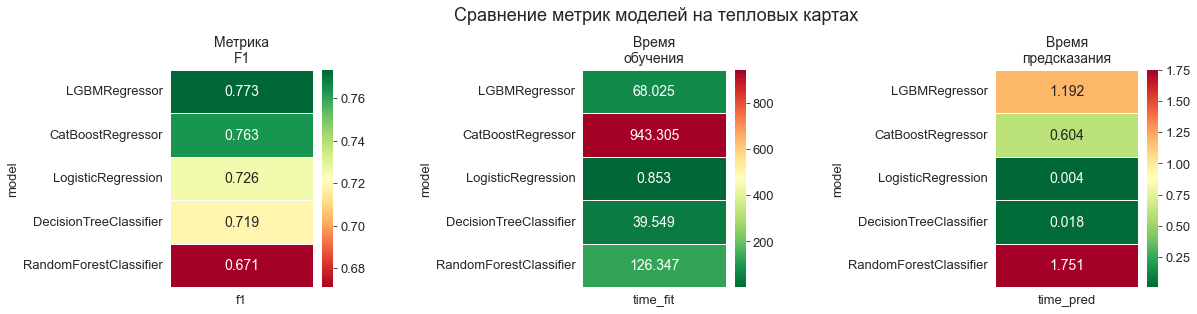

In [40]:
def compare_metrics(metrics: pd.DataFrame):    
    fig, ax = plt.subplots(1, 3, figsize=(18,4))
    
    fig.subplots_adjust(wspace=1.3)
    
    fig.suptitle('Сравнение метрик моделей на тепловых картах', y = 1.1, fontsize = 18)
    
    for i, cmap, title, met in zip(range(3),
                                          ['RdYlGn', 'RdYlGn_r', 'RdYlGn_r'],
                                          ['Метрика\nF1',
                                           'Время\nобучения',
                                           'Время\nпредсказания'],                                            
                                           ['f1', 'time_fit', 'time_pred']):
        
        metrics_heat = metrics[[met]]
        
        sns.heatmap(metrics_heat,
                    annot=True,
                    annot_kws={"size": 14},
                    fmt= '.3f',
                    ax=ax[i],
                    cmap=cmap,
                    linewidths=1.0)
        
        ax[i].set_title(f'{title}', fontsize = 14, y=1.005);
        
compare_metrics(metrics_all)

- Качество моделей бустинга лучше остальных моделей.
- Лучшая по качеству и времени обучения модель - `LGBMClassifier`.
- Для заказчика наиболее оптимальной является модель `LGBMClassifier`.

### Проверка качества лучшей модели на тестовой выборке

#### Функция обучения, предсказаний и получения метрик модели на тесте

Cоздадим функцию `test_metrics()`.

На входе функции:
- `model_name` - наименование модели классификации
- `parameter_change` - наименование изменяемого гиперпараметра
- `parameter_range` - диапазон изменения гиперпараметра
- `parameters_other` - словарь дополнительных параметров, если дополнительные параметры отсутствуют, то необходимо передать пустой словарь {}

На выходе функции:
- `model_best` - лучшая модель
- `metrics` - датафрейм с метриками модели
- `f1_best` - лучшее значение метрики `F1`

Датафрейм `metrics`:
- `model` - модель     
- `f1` - значение метрики F1 для выбранной модели      
- `f1_base` - значение метрики F1 для базовой (константной) модели   
- `f1_max` - предельное значение метрики F1 согласно исходным данным
- `sanity` - вменяемость модели (**True** - вменяема, **False** - нет)    
- `quality` - качество модели относительно предельного (**True** - лучше, **False** - хуже)    
- `time_fit` - время обучения модели 
- `time_pred` - время предсказания модели
- `f'{parameter_change}'` - значения изменяемого гиперпараметра

Функция также выполняет визуализацию результатов на тепловых картах.

In [41]:
def test_metrics(model:'ModelClassifier with hyperparameters',
                 test_tfidf,
                 y_test):    
   
    '''Предсказания модели'''
    
    predictions = model.predict(test_tfidf)                       # предсказания модели
    
    f1 = f1_score(y_test, predictions)                            # вычисление F1    
    quality = (f1 > f1_min)        
   
    '''Вывод метрик'''
    
    metrics = pd.DataFrame({'f1'      : [f1],
                            'f1_min'  : [f1_min],
                            'quality' : [quality]}) 
    
    display(metrics)    
   
    if f1 > f1_min:
        print(color.OKGREEN+color.BOLD+'Качество выбранной модели лучше предельного по исходным данным.'+color.END)
    else:
        print(color.FAIL+color.BOLD+'Качество выбранной модели уступает предельному по исходным данным.'+color.END)      
      
    return metrics, f1

#### Проверка качества модели, обученной на 60% данных, на тесте

In [42]:
metrics_test_60, f1_test_60 = test_metrics(model_light, test_tfidf, y_test)

,f1,f1_min,quality
0,0.779,0.750,True


Качество выбранной модели лучше предельного по исходным данным.


### Проверка качества модели, обученной на 80% данных

#### Создание переменных для фичей и таргета, деление на выборки

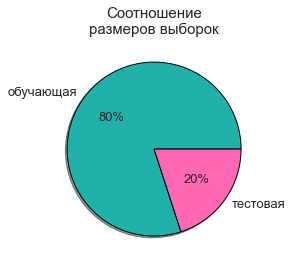

In [43]:
(y_80,
 y_train_80,
 y_test_80,
 X_80,
 X_train_80,
 X_test_80) = split_data (df, valid = False)

#### TF-IDF

Оценка важности слова определяется величиной `TF-IDF` (от англ. term frequency, «частота терма, или слова»; inverse document frequency, «обратная частота документа, или текста»).

`TF` отвечает за количество упоминаний слова в отдельном тексте, а `IDF` отражает частоту его употребления во всём корпусе.

Вычислим `TF-IDF` для корпусов текстов.

Функцию `fit()` запускаем только на обучающей выборке, иначе тестирование будет нечестным: в модели будут учтены частоты слов из тестовой выборки.

In [44]:
count_tf_idf_80 = TfidfVectorizer(stop_words=stopwords)     # создадим счётчик, указав в нём стоп-слова
train_tfidf_80  = count_tf_idf_80.fit_transform(X_train_80) # обучение и расчёт TF-IDF для корпуса текстов train
test_tfidf_80   = count_tf_idf_80.transform(X_test_80)      # расчёт TF-IDF для корпуса текстов test

#### Обучение, предсказания и получение метрик модели

,model,f1,f1_base,f1_min,sanity,quality,time_fit,time_pred,max_depth
0,<class 'lightgbm.sklearn.LGBMClassifier'>,0.840,0.171,0.750,True,True,56.920,3.530,5
1,<class 'lightgbm.sklearn.LGBMClassifier'>,0.967,0.171,0.750,True,True,159.762,15.026,50


Качество выбранной модели лучше базового уровня, модель вменяема.
Качество выбранной модели лучше предельного по исходным данным.
CPU times: total: 15min 10s
Wall time: 3min 55s


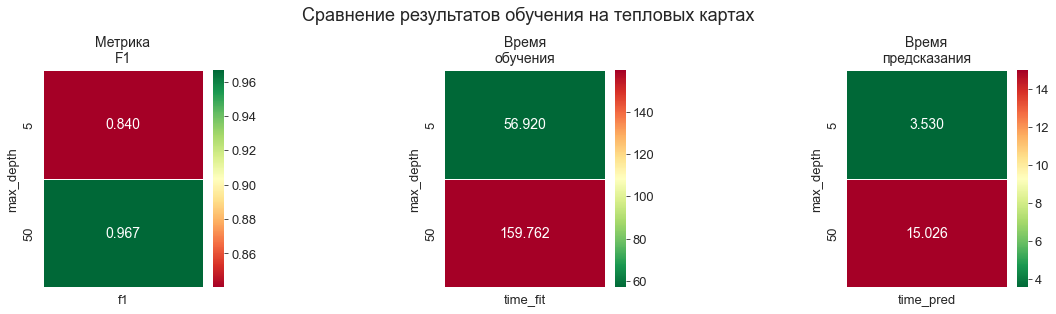

In [45]:
%%time
model_light_80, metrics_light_80, f1_light_80 = model_metrics(LGBMClassifier,
                                                              'max_depth',
                                                              [5, 50],
                                                              {'learning_rate':0.1},
                                                              train_tfidf_80,
                                                              y_train_80,
                                                              valid = False)

#### Проверка качества модели, обученной на 80% данных, на тесте

In [46]:
metrics_test_80, f1_test_80 = test_metrics(model_light_80, test_tfidf_80, y_test_80)

,f1,f1_min,quality
0,0.780,0.750,True


Качество выбранной модели лучше предельного по исходным данным.


#### Лучшая модель

Гиперпараметры лучшей модели

In [47]:
model_light_80.set_params()

LGBMClassifier(force_col_wise=True, max_depth=50, n_estimators=1000,
               num_leaves=40, random_state=2007)

Качество лучшей модели

In [48]:
print(f'F1 лучшей модели: {f1_test_80:.3f}')

F1 лучшей модели: 0.780


## Выводы

Для интернет-магазина «Викишоп»:
- предоставленные данные подготовлены для машинного обучения,
- проведено машинное обучение,
- выбрана лучшая по критериям заказчика модель, качество которой проверено на тестовой выборке.

Заказчику предоставлен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.